## 패키지 불러오기

In [1]:
# 라이브러리
# Data Preprocessing Package
import re
import numpy as np
import pandas as pd
import os
import itertools
import math
from pprint import pprint
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLP Package
from konlpy.tag import * 
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from collections import Counter

import sys
import nltk
from nltk import FreqDist

In [2]:
# 시각화
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline
plt.rcParams['font.family'] = 'NanumGothic'

## 형태소 분석기 (KIWI)

In [6]:
from kiwipiepy import Kiwi

In [7]:
kiwi = Kiwi()

In [32]:
#불용어 처리 단어 불러오기
file_path = r'C:\Users\user\Desktop\새 폴더\data\stopwords.txt'

# Read the file and extract stopwords
with open(file_path, 'r', encoding='utf-8') as file:
    stopwords = [word.strip() for word in file]

In [33]:
stopwords

['기자',
 '이번',
 '올해',
 '군수',
 '지난해',
 '무안',
 '신안',
 '홍어',
 '이후',
 '경우',
 '가운데',
 '이날',
 '버스',
 '오후',
 '내년',
 '이하',
 '그동안',
 '하반기',
 '박홍',
 '한편',
 '제외',
 '모두',
 '상반기',
 '곳곳',
 '이달',
 '마지막',
 '미만',
 '오른쪽',
 '최다',
 '하나님',
 '직후',
 '여름철',
 '전후',
 '서훈',
 '절대',
 '어제',
 '직전',
 '즉시',
 '슬기',
 '북쪽',
 '2관',
 '아무것',
 '동쪽',
 '첫해',
 '첫발',
 '와중',
 '살맛',
 '간만',
 '최남규',
 '부사장',
 '한쪽',
 '여기저기',
 '양쪽',
 '뜬금포',
 '일쑤',
 '황경혜',
 '적재적소',
 '이틀간',
 '"꺠끗',
 '"넥스트',
 '"소담"',
 '"오룡"',
 '"워커블"',
 '"재재"',
 '"조호"',
 '"킨더슐"',
 '%포인트',
 '&더포레',
 '&초코플',
 '(1',
 '(3',
 '*연시회',
 '*위드',
 '.노',
 '․도초',
 '.소매',
 '.소악도',
 '.유달',
 '：7',
 '?고교',
 '?무',
 '?정',
 '?지',
 '?치유',
 '?해',
 '~도초',
 '~비',
 '~암태',
 '~추포',
 '△강대',
 '△권호',
 '▲귀어',
 '△귀어',
 '▲나주',
 '△내재해',
 '△뇌',
 '△동교마',
 '△박효',
 '△선샤',
 '△섬드리마',
 '▲세',
 '△세',
 '△세무회계',
 '▲송무',
 '△스마트팜',
 '△암태',
 '▲오룡',
 '△윤재',
 '△이오',
 '▲조파',
 '△조파',
 '▲폐',
 '▷귀어',
 '▷서한태',
 '▷이',
 '◆괭',
 '·3',
 '·귀어',
 '·언택트',
 '·오룡',
 '·오룡지구',
 '·오룡지구',
 '·오프',
 '·짱둥어',
 '·하당구',
 '･시야',
 '…귀어',
 '1뮤지움',


In [34]:
# 일반 명사(NNP) 추출 버전
def extract_nouns_1(text):
    for token in kiwi.tokenize(text):
        if token.tag in {'NNG'} and len(token.form) >= 2:
            yield token.form

In [35]:
# 일반 명사(NNP) 추출 & 불용어 처리 버전
def extract_nouns_2(text, stopwords):
    for token in kiwi.tokenize(text):
        # 명사이면서 길이가 2 이상이고 stopwords에 포함되지 않은 경우에만 추출
        if token.tag == 'NNG' and len(token.form) >= 2 and token.form not in stopwords:
            yield token.form

## 데이터 확인

In [36]:
path = r'C:\Users\user\Desktop\새 폴더\data\빅카인즈_통합.xlsx'  

In [37]:
df = pd.read_excel(path)
df

,Author,Title,Content
0,목포,[사설] 생활권 침해 없는데 봉안당 불허···님비에 법원 제동,극단적인 지역이기주의에 지역 현안들이 발목이 잡혀있는 가운데 법원이 과도한 님비현상...
1,목포,“학생 수 감소했다면 학교용지비용 부담 필요 없어”,[KBS 광주]\n취학 인구가 감소했는데도 학교용지부담금을 부과한 행정처분은 부당하...
2,목포,"경단녀서 꽃가게 사장님으로… ""지방은 기회의 공간"" [지방시대 지방영웅]",<4> 전남 목포 '두리하나 플라워' 임효백씨 아이 때문에 결심한 '지방살이'서 꿈...
3,목포,"장수군장애인탁구단 이근우 선수 ""장애는 불편할 뿐 불행한 것 아냐”",항저우아시안게임 메달 이근우 선수\n“만약 세상에 즐거움만 있다면 우리는 결코 인내...
4,목포,"전남도, 청소년 지원 종합 거점공간 23일 개청",전남청소년미래재단 상담·안전망 구축·자기개발 기회 제공 등 종합 지원 거점 공연장·...
...,...,...,...
4532,신안,"신년특집>""딸기 엉글때 청년농 '농촌의 희망' 될터""",청년농부가 미래다=신안 딸기학교 교육생\n지난달 천사섬 딸기영농조합법인을 출범시킨 ...
4533,신안,"새해특집>신안팔금면 딸기농장, 청년농업인 교육…""군수님 역점사업이죠""",청년농 실패 최소화…연중 딸기 생산 가능\n청년 예비농부 5명이 입학한 신안 팔금면...
4534,신안,"새해특집>""스마트 딸기 재배기술로 청년농업인 우상 될래요""",청년농부가 미래다=신안 딸기학교 교육생 5명\n지난달 천사섬 딸기영농조합법인을 출범...
4535,신안,[신년사] 김종식 목포시장,김종식 목포시장\n존경하는 시민 여러분! 그리고 동료 공직자 여러분! 2021년 새...


In [38]:
# 추출 단어 확인(10개 이상)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(tokenizer=extract_nouns_1 , min_df=10)
dtm = cv.fit_transform(df.Content)

c:\Users\user\anaconda3\envs\PY39_\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [39]:
word_count = pd.DataFrame({
    'word': cv.get_feature_names_out(),
    'count': dtm.sum(axis=0).flat
})

In [41]:
word_count.sort_values('count', ascending=False)
a = pd.DataFrame(word_count.sort_values('count', ascending=False))
a.to_excel(r"C:/Users/user/Desktop/새 폴더/data/extract_nouns.xlsx")

In [42]:
a = pd.DataFrame(word_count.sort_values('count', ascending=False))

In [43]:
a.to_excel(r"C:/Users/user/Desktop/새 폴더/data/extract_nouns.xlsx")

In [44]:
df['Extracted_Nouns'] = df['Content'].apply(lambda x: list(extract_nouns_2(x, stopwords)))

In [45]:
df

,Author,Title,Content,Extracted_Nouns
0,목포,[사설] 생활권 침해 없는데 봉안당 불허···님비에 법원 제동,극단적인 지역이기주의에 지역 현안들이 발목이 잡혀있는 가운데 법원이 과도한 님비현상...,"[극단, 지역, 이기주의, 지역, 현안, 발목, 법원, 과도, 님비, 현상, 제동,..."
1,목포,“학생 수 감소했다면 학교용지비용 부담 필요 없어”,[KBS 광주]\n취학 인구가 감소했는데도 학교용지부담금을 부과한 행정처분은 부당하...,"[취학, 인구, 감소, 학교, 용지, 부담금, 부과, 행정, 처분, 부당, 판결, ..."
2,목포,"경단녀서 꽃가게 사장님으로… ""지방은 기회의 공간"" [지방시대 지방영웅]",<4> 전남 목포 '두리하나 플라워' 임효백씨 아이 때문에 결심한 '지방살이'서 꿈...,"[두리하나, 플라워, 아이, 결심, 지방, 청년, 공간, 다양, 창업, 기회, 제공..."
3,목포,"장수군장애인탁구단 이근우 선수 ""장애는 불편할 뿐 불행한 것 아냐”",항저우아시안게임 메달 이근우 선수\n“만약 세상에 즐거움만 있다면 우리는 결코 인내...,"[아시안, 게임, 메달, 선수, 세상, 즐거움, 인내, 장애, 불편, 불행, 장애인..."
4,목포,"전남도, 청소년 지원 종합 거점공간 23일 개청",전남청소년미래재단 상담·안전망 구축·자기개발 기회 제공 등 종합 지원 거점 공연장·...,"[청소년, 미래, 재단, 상담, 안전, 구축, 자기, 개발, 기회, 제공, 종합, ..."
...,...,...,...,...
4532,신안,"신년특집>""딸기 엉글때 청년농 '농촌의 희망' 될터""",청년농부가 미래다=신안 딸기학교 교육생\n지난달 천사섬 딸기영농조합법인을 출범시킨 ...,"[청년, 농부, 미래, 딸기, 학교, 교육, 지난달, 천사, 딸기, 영농, 조합, ..."
4533,신안,"새해특집>신안팔금면 딸기농장, 청년농업인 교육…""군수님 역점사업이죠""",청년농 실패 최소화…연중 딸기 생산 가능\n청년 예비농부 5명이 입학한 신안 팔금면...,"[청년, 실패, 최소, 연중, 딸기, 생산, 가능, 청년, 예비, 농부, 입학, 딸..."
4534,신안,"새해특집>""스마트 딸기 재배기술로 청년농업인 우상 될래요""",청년농부가 미래다=신안 딸기학교 교육생 5명\n지난달 천사섬 딸기영농조합법인을 출범...,"[청년, 농부, 미래, 딸기, 학교, 교육, 지난달, 천사, 딸기, 영농, 조합, ..."
4535,신안,[신년사] 김종식 목포시장,김종식 목포시장\n존경하는 시민 여러분! 그리고 동료 공직자 여러분! 2021년 새...,"[시장, 존경, 시민, 동료, 공직자, 새해, 소원, 성취, 기원, 발전, 성원, ..."


In [46]:
# 괄호나 띄어쓰기 등은 replace로 제거
df['Extracted_Nouns'] = df['Extracted_Nouns'].apply(lambda x : str(x))
df['Extracted_Nouns'] = df['Extracted_Nouns'].apply(lambda x : x.replace("[", "").replace("]", "").replace(",", "").replace("'", ""))

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4537 entries, 0 to 4536
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Author           4537 non-null   object
 1   Title            4537 non-null   object
 2   Content          4537 non-null   object
 3   Extracted_Nouns  4537 non-null   object
dtypes: object(4)
memory usage: 141.9+ KB


In [48]:
# # 결측값이 있는 행 제거
# df = df.dropna(axis=0)
# df

In [49]:
# 토큰을 저장한 컬럼을 변수로 지정
only_token_df = df['Extracted_Nouns']

In [50]:
# 토크나이징한 최종 토큰 수 산출
total_tokens = [token for msg in only_token_df for token in str(msg).split()]
print(len(total_tokens))

903524


In [51]:
pd.DataFrame(total_tokens).to_excel(r"C:/Users/user/Desktop/새 폴더/data/extract_nouns.xlsx")

In [52]:
text = nltk.Text(total_tokens, name='NNG')
print(len(set(text.tokens))) # 고유 토큰 수 반환
print(text.vocab().most_common(10)) # 가장 많이 등장한 토큰 10개와 빈도 수 산출

18945
[('지역', 12130), ('교육', 9838), ('사업', 9374), ('지원', 7861), ('문화', 5512), ('추진', 4672), ('운영', 4020), ('계획', 3758), ('청년', 3707), ('주민', 3657)]


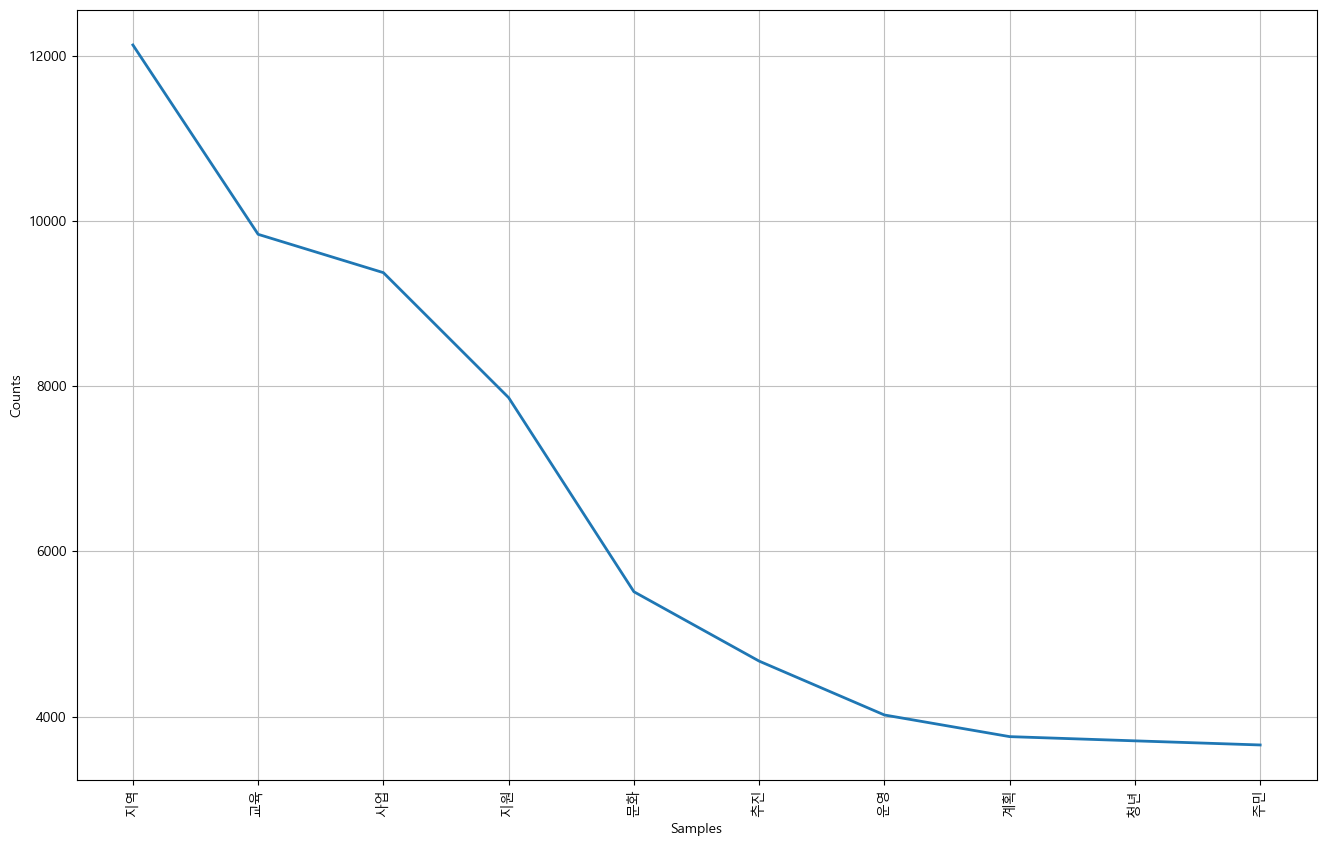

<Axes: xlabel='Samples', ylabel='Counts'>

In [53]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(16, 10))
text.plot(10)

# 워드클라우드를 위한 토큰별 빈도수 dict 저장

In [54]:
from wordcloud import WordCloud

In [57]:
wordcloud = WordCloud().generate(total_tokens)

TypeError: expected string or bytes-like object

In [56]:
vocab_dict

NameError: name 'vocab_dict' is not defined

In [90]:
import pickle

# vocab_dict를 저장할 파일 이름
file_name = r'C:/Users/user/Desktop/새 폴더/data/wordcliud_dict.pkl'

# vocab_dict 저장
with open(file_name, 'wb') as file:
    pickle.dump(vocab_dict, file)

## 전처리 및 토큰화 완료 파일 저장

In [58]:
path_df_final = r"C:\Users\user\Desktop\새 폴더\data\빅카인즈_통합_final.xlsx"

In [59]:
df.to_excel(path_df_final, index=False)

# 워드클라우드

In [65]:
from wordcloud import WordCloud

In [66]:
wc = WordCloud(random_state = 123, font_path = 'Malgun Gothic', width = 400,
               height = 400, background_color = 'white')

In [67]:
img_wordcloud = wc.generate_from_frequencies(text.vocab())

OSError: cannot open resource

In [64]:
a = text.vocab()